In [1]:
import sys
import pandas as pd
import ast
import pickle
import random
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scanpy as sc
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import networkx as nx
from torch_geometric.utils import from_networkx
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, precision_recall_curve, r2_score, mean_absolute_error, mean_squared_error
from scipy.special import inv_boxcox

from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())

sys.path.append('../src/null-effect-net')
import utils
import models
import dataset
import train_utils

In [2]:
class GNNRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=32):
        super().__init__()
        
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(output_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # 1 logit
        )
    
    def forward(self, data, query_node_indices):
        # data.x: (num_nodes, feature_dim)
        # data.edge_index: (2, num_edges)
        data.x = data.x.to(torch.float32)
        
        x = self.conv1(data.x, data.edge_index)
        x = F.relu(x)
        x = self.conv2(x, data.edge_index)
        x = F.relu(x)
        
        # Only select embeddings for the query nodes
        query_embeddings = x[query_node_indices]
        
        logits = self.mlp(query_embeddings)
        return logits.squeeze(-1)

    def compute_loss(self, logits, labels):
        return F.mse_loss(preds, targets)


In [3]:
class PerturbationDataset(Dataset):
    def __init__(self, label_df, active_nodes_df, node_features_df, node_idx_mapping, device='cpu'):
        self.label_df = label_df.reset_index(drop=True)
        self.device = device
        self.node_idx_mapping = node_idx_mapping  # Mapping from Ensembl ID to node index

        # Build mapping from (Cell Line) to list of active genes (may be useful later)
        self.cell_line_to_active = (
            active_nodes_df.groupby("Cell Line")["Gene"]
            .apply(list)
            .to_dict()
        )

    def __len__(self):
        return len(self.label_df)

    def __getitem__(self, idx):
        row = self.label_df.iloc[idx]
        target_id = row["Target"]
        label = torch.tensor(row["e_distance_transformed"], dtype=torch.float32).to(self.device)

        # Map target Ensembl ID to node index
        try:
            target_idx = self.node_idx_mapping[target_id]
        except KeyError:
            raise ValueError(f"Target node '{target_id}' not found in node_idx_mapping.")

        return target_idx, label

def collate_function(batch):
    target_indices, labels = zip(*batch)
    target_indices = torch.tensor(target_indices, dtype=torch.long)
    labels = torch.stack(labels)
    return target_indices, labels

In [4]:
id_map_df = pd.read_csv('../data/id_mappings/gene_ref.tsv', sep='\t')
id_map_df

,HGNC ID,Approved symbol,Approved name,Status,Previous symbols,Alias symbols,Chromosome,Accession numbers,RefSeq IDs,NCBI Gene ID,Ensembl gene ID,Mouse genome database ID,Pubmed IDs,Alias names
0,HGNC:5,A1BG,alpha-1-B glycoprotein,Approved,NaN,NaN,19q13.43,NaN,NM_130786,1.0,ENSG00000121410,MGI:2152878,2591067,NaN
1,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,Approved,"NCRNA00181, A1BGAS, A1BG-AS",FLJ23569,19q13.43,BC040926,NR_015380,503538.0,ENSG00000268895,NaN,NaN,NaN
2,HGNC:24086,A1CF,APOBEC1 complementation factor,Approved,NaN,"ACF, ASP, ACF64, ACF65, APOBEC1CF",10q11.23,AF271790,NM_014576,29974.0,ENSG00000148584,MGI:1917115,"11815617, 11072063",NaN
3,HGNC:6,A1S9T,"symbol withdrawn, see [HGNC:12469](/data/gene-...",Symbol Withdrawn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HGNC:7,A2M,alpha-2-macroglobulin,Approved,NaN,"FWP007, S863-7, CPAMD5",12p13.31,"BX647329, X68728, M11313",NM_000014,2.0,ENSG00000175899,MGI:2449119,"2408344, 9697696",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49354,HGNC:25820,ZYG11B,"zyg-11 family member B, cell cycle regulator",Approved,ZYG11,FLJ13456,1p32.3,AB051517,NM_024646,79699.0,ENSG00000162378,MGI:2685277,11214970,NaN
49355,HGNC:13200,ZYX,zyxin,Approved,NaN,NaN,7q34,X95735,NM_003461,7791.0,ENSG00000159840,MGI:103072,"8917469, 8940160",NaN
49356,HGNC:51695,ZYXP1,zyxin pseudogene 1,Approved,NaN,NaN,8q24.23,NaN,NaN,NaN,ENSG00000274572,NaN,NaN,NaN
49357,HGNC:29027,ZZEF1,zinc finger ZZ-type and EF-hand domain contain...,Approved,NaN,"KIAA0399, ZZZ4, FLJ10821",17p13.2,BC035319,NM_015113,23140.0,ENSG00000074755,MGI:2444286,9455477,NaN


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_utils.set_seed(42)

In [6]:
with open('../data/embeddings.pkl', 'rb') as f:
    node_features_df = pickle.load(f)

node_features_df['Concat Embedding'] = node_features_df['ESM Embedding'] + node_features_df['SubCell Embedding'] + node_features_df['PINNACLE Embedding']

train_df = pd.read_csv('../data/perturbation_screens/e_distance/train.csv', index_col=0)

active_nodes_df = pd.read_csv('../data/expression_reference/expression_reference.csv', index_col=0)

G = nx.read_edgelist('../data/networks/global_ppi_edgelist.txt')

ensembl_to_node = dict(zip(id_map_df['Ensembl gene ID'], id_map_df['Approved symbol']))
node_to_ensembl = dict(zip(id_map_df['Approved symbol'], id_map_df['Ensembl gene ID']))

G = nx.relabel_nodes(G, node_to_ensembl)

# Get set of nodes that have features
valid_nodes = set(node_features_df['Ensembl ID'])

# Remove nodes from G that are not in valid_nodes
G.remove_nodes_from([n for n in list(G.nodes) if n not in valid_nodes])

node_to_idx = {node: idx for idx, node in enumerate(G.nodes())}

train_df = train_df[train_df['Target'].isin(G.nodes())]

# Convert to edge_index format
data = from_networkx(G)

features = torch.stack([
    torch.tensor(node_features_df.set_index('Ensembl ID').loc[idx]['Concat Embedding'])
    for idx in G.nodes()
])
data.x = features

train_dataset = PerturbationDataset(
    train_df.iloc[:int(0.9*len(train_df))],
    active_nodes_df,
    node_features_df,
    node_to_idx,
    device=device
)

val_dataset = PerturbationDataset(
    train_df.iloc[int(0.9*len(train_df)):],
    active_nodes_df,
    node_features_df,
    node_to_idx,
    device=device
)

input_dim = len(node_features_df['Concat Embedding'][0])

model = GNNRegressor(
    input_dim=input_dim, 
    hidden_dim=512, 
    output_dim=128
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_function)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_function)

In [7]:
train_df

,Target,e_distance,p_value,experiment,Perturbed,e_distance_transformed
1798,ENSG00000146425,0.701794,0.334000,GasperiniShendure2019_lowMOI_,False,-0.351767
2295,ENSG00000134809,4.209333,0.001996,ReplogleWeissman2022_rpe1_,True,1.476856
802,ENSG00000108312,0.085282,0.149701,ReplogleWeissman2022_K562_essential_,False,-2.351265
709,ENSG00000124380,1.066327,0.001996,ReplogleWeissman2022_K562_essential_,True,0.064298
1509,ENSG00000243927,0.227439,0.001996,ReplogleWeissman2022_K562_essential_,True,-1.440390
...,...,...,...,...,...,...
1251,ENSG00000187778,0.408868,0.001996,ReplogleWeissman2022_K562_essential_,True,-0.879488
3914,ENSG00000104889,0.305057,0.001996,FrangiehIzar2021_RNA_,True,-1.161140
245,ENSG00000132603,1.493626,0.001996,ReplogleWeissman2022_K562_essential_,True,0.404249
1039,ENSG00000179409,0.738596,0.001996,ReplogleWeissman2022_K562_essential_,True,-0.301284


In [22]:
def train_one_epoch(model, data, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0
    y_true, y_pred = [], []

    for batch_idx, (query_node_indices, labels) in enumerate(dataloader):
        query_node_indices = query_node_indices.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        preds = model(data, query_node_indices)
        loss = F.mse_loss(preds, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        y_true.extend(labels.detach().cpu().numpy())
        y_pred.extend(preds.detach().cpu().numpy())
        total_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"[Batch {batch_idx+1}] Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(dataloader)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)

    print(f"\n[Training] Loss: {avg_loss:.4f} | R²: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")
    return {'loss': avg_loss, 'r2': r2, 'mae': mae, 'rmse': rmse}


def evaluate(model, data, dataloader, device, inverse_transform_fn=None):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for query_node_indices, labels in dataloader:
            query_node_indices = query_node_indices.to(device)
            labels = labels.to(device)

            preds = model(data, query_node_indices)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    if inverse_transform_fn:
        y_true = inverse_transform_fn(np.array(y_true))
        y_pred = inverse_transform_fn(np.array(y_pred))

    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)

    print(f"\n[Evaluation] R²: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")
    return {'r2': r2, 'mae': mae, 'rmse': rmse}, y_true, y_pred


# Training loop across multiple epochs
num_epochs = 20
best_val_r2 = -float('inf')
lmbda = 0.03760410204704832
inverse_transform_fn = lambda x: inv_boxcox(x, lmbda)

for epoch in range(1, num_epochs + 1):
    print(f"\n===== Epoch {epoch}/{num_epochs} =====")
    train_metrics = train_one_epoch(model, data, train_loader, optimizer, device)
    val_metrics, y_true_val, y_pred_val = evaluate(model, data, val_loader, device, inverse_transform_fn=inverse_transform_fn)

    if val_metrics['r2'] > best_val_r2:
        best_val_r2 = val_metrics['r2']
        torch.save(model.state_dict(), 'best_model_regression.pt')
        print(f"New best model saved with R²: {best_val_r2:.4f}")


===== Epoch 1/20 =====
[Batch 10] Loss: 2.1359
[Batch 20] Loss: 1.1081
[Batch 30] Loss: 1.9157
[Batch 40] Loss: 1.7581
[Batch 50] Loss: 1.3180
[Batch 60] Loss: 1.2823
[Batch 70] Loss: 1.5441
[Batch 80] Loss: 1.0204
[Batch 90] Loss: 1.4347
[Batch 100] Loss: 3.4249
[Batch 110] Loss: 1.0553
[Batch 120] Loss: 1.7468
[Batch 130] Loss: 1.9720
[Batch 140] Loss: 2.1269
[Batch 150] Loss: 1.3769
[Batch 160] Loss: 1.6084
[Batch 170] Loss: 1.7748


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Training] Loss: 1.8194 | R²: 0.1482 | MAE: 1.1119 | RMSE: 1.3490


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Evaluation] R²: 0.1658 | MAE: 1.8120 | RMSE: 2.8260
New best model saved with R²: 0.1658

===== Epoch 2/20 =====
[Batch 10] Loss: 0.9643
[Batch 20] Loss: 2.6115
[Batch 30] Loss: 1.6596
[Batch 40] Loss: 2.1408
[Batch 50] Loss: 1.2126
[Batch 60] Loss: 1.3639
[Batch 70] Loss: 1.7891
[Batch 80] Loss: 2.1633
[Batch 90] Loss: 1.7646
[Batch 100] Loss: 1.5412
[Batch 110] Loss: 2.0187
[Batch 120] Loss: 1.2058
[Batch 130] Loss: 2.1606
[Batch 140] Loss: 2.4220
[Batch 150] Loss: 1.6557
[Batch 160] Loss: 2.3381
[Batch 170] Loss: 1.5651


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Training] Loss: 1.8192 | R²: 0.1482 | MAE: 1.1119 | RMSE: 1.3490


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Evaluation] R²: 0.1658 | MAE: 1.8120 | RMSE: 2.8260

===== Epoch 3/20 =====
[Batch 10] Loss: 1.5230
[Batch 20] Loss: 2.0016
[Batch 30] Loss: 1.5565
[Batch 40] Loss: 2.2193
[Batch 50] Loss: 1.6314
[Batch 60] Loss: 0.7562
[Batch 70] Loss: 1.3019
[Batch 80] Loss: 1.9331
[Batch 90] Loss: 2.0546
[Batch 100] Loss: 1.7325
[Batch 110] Loss: 2.7522
[Batch 120] Loss: 2.0443
[Batch 130] Loss: 1.5147
[Batch 140] Loss: 2.5180
[Batch 150] Loss: 2.5626
[Batch 160] Loss: 2.4202
[Batch 170] Loss: 1.5607


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Training] Loss: 1.8196 | R²: 0.1482 | MAE: 1.1119 | RMSE: 1.3490


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Evaluation] R²: 0.1658 | MAE: 1.8120 | RMSE: 2.8260

===== Epoch 4/20 =====
[Batch 10] Loss: 1.3135
[Batch 20] Loss: 1.8951
[Batch 30] Loss: 0.9722
[Batch 40] Loss: 1.2179
[Batch 50] Loss: 1.9746
[Batch 60] Loss: 1.3604
[Batch 70] Loss: 1.5215
[Batch 80] Loss: 2.4627
[Batch 90] Loss: 1.4072
[Batch 100] Loss: 1.8949
[Batch 110] Loss: 1.5162
[Batch 120] Loss: 1.4594
[Batch 130] Loss: 1.3225
[Batch 140] Loss: 1.8139
[Batch 150] Loss: 1.1375
[Batch 160] Loss: 1.7073
[Batch 170] Loss: 1.8885


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Training] Loss: 1.8192 | R²: 0.1482 | MAE: 1.1119 | RMSE: 1.3490


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Evaluation] R²: 0.1658 | MAE: 1.8120 | RMSE: 2.8260

===== Epoch 5/20 =====
[Batch 10] Loss: 2.2210
[Batch 20] Loss: 1.3185
[Batch 30] Loss: 1.5757
[Batch 40] Loss: 1.9670
[Batch 50] Loss: 3.0306
[Batch 60] Loss: 1.2084
[Batch 70] Loss: 1.7176
[Batch 80] Loss: 1.0323
[Batch 90] Loss: 1.7681
[Batch 100] Loss: 1.2846
[Batch 110] Loss: 1.7372
[Batch 120] Loss: 1.4018
[Batch 130] Loss: 2.4472
[Batch 140] Loss: 1.2110
[Batch 150] Loss: 1.5903
[Batch 160] Loss: 2.5809
[Batch 170] Loss: 0.9779


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Training] Loss: 1.8200 | R²: 0.1482 | MAE: 1.1119 | RMSE: 1.3490


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Evaluation] R²: 0.1658 | MAE: 1.8120 | RMSE: 2.8260

===== Epoch 6/20 =====
[Batch 10] Loss: 1.0700
[Batch 20] Loss: 1.6699
[Batch 30] Loss: 1.9143
[Batch 40] Loss: 0.8877
[Batch 50] Loss: 1.7498
[Batch 60] Loss: 1.5495
[Batch 70] Loss: 2.1562
[Batch 80] Loss: 1.2162
[Batch 90] Loss: 1.6637
[Batch 100] Loss: 1.3060
[Batch 110] Loss: 1.8439
[Batch 120] Loss: 1.3790
[Batch 130] Loss: 2.1507
[Batch 140] Loss: 1.2834
[Batch 150] Loss: 1.2681
[Batch 160] Loss: 1.9149
[Batch 170] Loss: 2.3473


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Training] Loss: 1.8195 | R²: 0.1482 | MAE: 1.1119 | RMSE: 1.3490


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Evaluation] R²: 0.1658 | MAE: 1.8120 | RMSE: 2.8260

===== Epoch 7/20 =====
[Batch 10] Loss: 1.2694
[Batch 20] Loss: 1.7839
[Batch 30] Loss: 1.0066
[Batch 40] Loss: 1.8889
[Batch 50] Loss: 1.9993
[Batch 60] Loss: 1.7499
[Batch 70] Loss: 0.9217
[Batch 80] Loss: 1.4721
[Batch 90] Loss: 1.0436
[Batch 100] Loss: 1.8302
[Batch 110] Loss: 1.4888
[Batch 120] Loss: 1.9416
[Batch 130] Loss: 2.5648
[Batch 140] Loss: 2.1629
[Batch 150] Loss: 2.8656
[Batch 160] Loss: 2.3433
[Batch 170] Loss: 1.5372


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Training] Loss: 1.8206 | R²: 0.1482 | MAE: 1.1119 | RMSE: 1.3490


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Evaluation] R²: 0.1658 | MAE: 1.8120 | RMSE: 2.8260

===== Epoch 8/20 =====
[Batch 10] Loss: 1.3601
[Batch 20] Loss: 1.1835
[Batch 30] Loss: 2.1289
[Batch 40] Loss: 2.0651
[Batch 50] Loss: 1.6008
[Batch 60] Loss: 2.7916
[Batch 70] Loss: 1.8169
[Batch 80] Loss: 1.9912
[Batch 90] Loss: 2.5937
[Batch 100] Loss: 1.4200
[Batch 110] Loss: 1.6781
[Batch 120] Loss: 2.0879
[Batch 130] Loss: 1.6811
[Batch 140] Loss: 1.9889
[Batch 150] Loss: 1.9505
[Batch 160] Loss: 1.7548
[Batch 170] Loss: 2.1282


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Training] Loss: 1.8200 | R²: 0.1482 | MAE: 1.1119 | RMSE: 1.3490


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Evaluation] R²: 0.1658 | MAE: 1.8120 | RMSE: 2.8260

===== Epoch 9/20 =====
[Batch 10] Loss: 2.9286
[Batch 20] Loss: 2.2172
[Batch 30] Loss: 1.6861
[Batch 40] Loss: 1.9909
[Batch 50] Loss: 1.3747
[Batch 60] Loss: 1.5801
[Batch 70] Loss: 1.6707
[Batch 80] Loss: 2.6278
[Batch 90] Loss: 2.1706
[Batch 100] Loss: 2.0801
[Batch 110] Loss: 1.2591
[Batch 120] Loss: 1.8350
[Batch 130] Loss: 1.2774
[Batch 140] Loss: 1.2736
[Batch 150] Loss: 2.4911
[Batch 160] Loss: 1.6300
[Batch 170] Loss: 2.8251


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Training] Loss: 1.8194 | R²: 0.1482 | MAE: 1.1119 | RMSE: 1.3490


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Evaluation] R²: 0.1658 | MAE: 1.8120 | RMSE: 2.8260

===== Epoch 10/20 =====
[Batch 10] Loss: 1.3015
[Batch 20] Loss: 1.1830
[Batch 30] Loss: 2.6259
[Batch 40] Loss: 1.8586
[Batch 50] Loss: 0.9512
[Batch 60] Loss: 1.3907
[Batch 70] Loss: 1.6143
[Batch 80] Loss: 1.5032
[Batch 90] Loss: 1.5273
[Batch 100] Loss: 2.2708
[Batch 110] Loss: 1.2380
[Batch 120] Loss: 1.5646
[Batch 130] Loss: 0.8956
[Batch 140] Loss: 1.8343
[Batch 150] Loss: 2.3890
[Batch 160] Loss: 2.1102
[Batch 170] Loss: 1.3459


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Training] Loss: 1.8197 | R²: 0.1482 | MAE: 1.1119 | RMSE: 1.3490


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Evaluation] R²: 0.1658 | MAE: 1.8120 | RMSE: 2.8260

===== Epoch 11/20 =====
[Batch 10] Loss: 2.0329
[Batch 20] Loss: 2.0560
[Batch 30] Loss: 1.9675
[Batch 40] Loss: 1.1830
[Batch 50] Loss: 1.5048
[Batch 60] Loss: 0.5782
[Batch 70] Loss: 2.1630
[Batch 80] Loss: 1.7700
[Batch 90] Loss: 2.1424
[Batch 100] Loss: 1.7176
[Batch 110] Loss: 0.9723
[Batch 120] Loss: 2.7271
[Batch 130] Loss: 1.4859
[Batch 140] Loss: 2.6219
[Batch 150] Loss: 1.3939
[Batch 160] Loss: 1.9357
[Batch 170] Loss: 1.2815


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Training] Loss: 1.8200 | R²: 0.1482 | MAE: 1.1119 | RMSE: 1.3490


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Evaluation] R²: 0.1658 | MAE: 1.8120 | RMSE: 2.8260

===== Epoch 12/20 =====
[Batch 10] Loss: 1.9830
[Batch 20] Loss: 1.8467
[Batch 30] Loss: 2.1725
[Batch 40] Loss: 1.7947
[Batch 50] Loss: 1.5576
[Batch 60] Loss: 1.5222
[Batch 70] Loss: 1.3548
[Batch 80] Loss: 0.7956
[Batch 90] Loss: 1.6337
[Batch 100] Loss: 1.3521
[Batch 110] Loss: 1.4951
[Batch 120] Loss: 2.0599
[Batch 130] Loss: 2.2930
[Batch 140] Loss: 1.1614
[Batch 150] Loss: 2.0446
[Batch 160] Loss: 1.9867
[Batch 170] Loss: 1.8336


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Training] Loss: 1.8196 | R²: 0.1482 | MAE: 1.1119 | RMSE: 1.3490


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Evaluation] R²: 0.1658 | MAE: 1.8120 | RMSE: 2.8260

===== Epoch 13/20 =====
[Batch 10] Loss: 2.2757
[Batch 20] Loss: 2.4831
[Batch 30] Loss: 1.6753
[Batch 40] Loss: 2.2095
[Batch 50] Loss: 2.2064
[Batch 60] Loss: 1.3430
[Batch 70] Loss: 1.5940
[Batch 80] Loss: 1.6740
[Batch 90] Loss: 2.1385
[Batch 100] Loss: 1.8467
[Batch 110] Loss: 3.2505
[Batch 120] Loss: 2.1228
[Batch 130] Loss: 1.1760
[Batch 140] Loss: 2.2380
[Batch 150] Loss: 2.3728
[Batch 160] Loss: 1.1308
[Batch 170] Loss: 2.1137


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Training] Loss: 1.8206 | R²: 0.1482 | MAE: 1.1119 | RMSE: 1.3490


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Evaluation] R²: 0.1658 | MAE: 1.8120 | RMSE: 2.8260

===== Epoch 14/20 =====
[Batch 10] Loss: 2.6103
[Batch 20] Loss: 1.4292
[Batch 30] Loss: 1.2370
[Batch 40] Loss: 1.4740
[Batch 50] Loss: 1.4406
[Batch 60] Loss: 1.0099
[Batch 70] Loss: 1.9536
[Batch 80] Loss: 1.3501
[Batch 90] Loss: 1.9903
[Batch 100] Loss: 1.3993
[Batch 110] Loss: 1.6550
[Batch 120] Loss: 2.6194
[Batch 130] Loss: 1.5202
[Batch 140] Loss: 1.3019
[Batch 150] Loss: 3.0384
[Batch 160] Loss: 1.5521
[Batch 170] Loss: 1.3145


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Training] Loss: 1.8196 | R²: 0.1482 | MAE: 1.1119 | RMSE: 1.3490


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Evaluation] R²: 0.1658 | MAE: 1.8120 | RMSE: 2.8260

===== Epoch 15/20 =====
[Batch 10] Loss: 1.2655
[Batch 20] Loss: 2.0825
[Batch 30] Loss: 1.1922
[Batch 40] Loss: 1.7700
[Batch 50] Loss: 1.2546
[Batch 60] Loss: 3.0482
[Batch 70] Loss: 0.9671
[Batch 80] Loss: 1.2989
[Batch 90] Loss: 1.6292
[Batch 100] Loss: 1.8337
[Batch 110] Loss: 1.3280
[Batch 120] Loss: 1.9950
[Batch 130] Loss: 1.3226
[Batch 140] Loss: 1.1069
[Batch 150] Loss: 2.8025
[Batch 160] Loss: 2.1017
[Batch 170] Loss: 1.8394


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Training] Loss: 1.8194 | R²: 0.1482 | MAE: 1.1119 | RMSE: 1.3490


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Evaluation] R²: 0.1658 | MAE: 1.8120 | RMSE: 2.8260

===== Epoch 16/20 =====
[Batch 10] Loss: 2.1481
[Batch 20] Loss: 2.2287
[Batch 30] Loss: 1.2389
[Batch 40] Loss: 2.2483
[Batch 50] Loss: 3.2804
[Batch 60] Loss: 1.9558
[Batch 70] Loss: 2.7353
[Batch 80] Loss: 2.1205
[Batch 90] Loss: 1.1242
[Batch 100] Loss: 1.8477
[Batch 110] Loss: 2.2743
[Batch 120] Loss: 1.6337
[Batch 130] Loss: 1.8653
[Batch 140] Loss: 1.7267
[Batch 150] Loss: 2.1779
[Batch 160] Loss: 1.7878
[Batch 170] Loss: 2.0062


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Training] Loss: 1.8193 | R²: 0.1482 | MAE: 1.1119 | RMSE: 1.3490


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Evaluation] R²: 0.1658 | MAE: 1.8120 | RMSE: 2.8260

===== Epoch 17/20 =====
[Batch 10] Loss: 2.5159
[Batch 20] Loss: 0.8492
[Batch 30] Loss: 1.6079
[Batch 40] Loss: 0.9782
[Batch 50] Loss: 1.1250
[Batch 60] Loss: 1.7647
[Batch 70] Loss: 2.2420
[Batch 80] Loss: 2.2387
[Batch 90] Loss: 2.1252
[Batch 100] Loss: 1.7381
[Batch 110] Loss: 1.6404
[Batch 120] Loss: 3.0744
[Batch 130] Loss: 1.2622
[Batch 140] Loss: 1.9499
[Batch 150] Loss: 1.4449
[Batch 160] Loss: 1.6221
[Batch 170] Loss: 1.4434


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Training] Loss: 1.8198 | R²: 0.1482 | MAE: 1.1119 | RMSE: 1.3490


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Evaluation] R²: 0.1658 | MAE: 1.8120 | RMSE: 2.8260

===== Epoch 18/20 =====
[Batch 10] Loss: 1.4892
[Batch 20] Loss: 1.1391
[Batch 30] Loss: 2.3301
[Batch 40] Loss: 1.4893
[Batch 50] Loss: 1.5213
[Batch 60] Loss: 1.8120
[Batch 70] Loss: 1.7872
[Batch 80] Loss: 1.6005
[Batch 90] Loss: 1.7508
[Batch 100] Loss: 2.6606
[Batch 110] Loss: 1.7567
[Batch 120] Loss: 1.5255
[Batch 130] Loss: 1.6701
[Batch 140] Loss: 1.2246
[Batch 150] Loss: 2.1641
[Batch 160] Loss: 1.8905
[Batch 170] Loss: 1.6515


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Training] Loss: 1.8198 | R²: 0.1482 | MAE: 1.1119 | RMSE: 1.3490


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[Evaluation] R²: 0.1658 | MAE: 1.8120 | RMSE: 2.8260

===== Epoch 19/20 =====
[Batch 10] Loss: 1.9887
[Batch 20] Loss: 1.3984
[Batch 30] Loss: 2.2800
[Batch 40] Loss: 1.3633
[Batch 50] Loss: 2.0772
[Batch 60] Loss: 1.7734
[Batch 70] Loss: 1.7584
[Batch 80] Loss: 1.2876
[Batch 90] Loss: 3.4366
[Batch 100] Loss: 1.6585
[Batch 110] Loss: 1.9350
[Batch 120] Loss: 1.1208
[Batch 130] Loss: 1.2273


KeyboardInterrupt: 

In [23]:
model = train_utils.load_model(GNNRegressor, input_dim=input_dim, hidden_dim=512, output_dim=128, path="best_model_regression.pt")

In [24]:
test_df = pd.read_csv('../data/perturbation_screens/e_distance/test.csv')

test_dataset = PerturbationDataset(
    test_df,
    active_nodes_df,
    node_features_df,
    node_to_idx,
    device=device
)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_function)

In [25]:
test_metrics, y_true, y_pred = evaluate(model, data, test_loader, device, inverse_transform_fn=inverse_transform_fn)
print(test_metrics)


[Evaluation] R²: -3.2072 | MAE: 2.2556 | RMSE: 6.7193
{'r2': -3.2071919441223145, 'mae': np.float32(2.2556434), 'rmse': np.float32(6.719266)}


/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [26]:
result_df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
result_df

,y_true,y_pred
0,0.692725,1.634421
1,0.141342,1.913493
2,1.657657,2.794052
3,2.525064,1.343393
4,0.111707,0.536738
...,...,...
791,1.646705,1.115803
792,7.186268,1.406069
793,0.269451,2.572081
794,1.400873,1.878057


n_outlier=1


(0.0, 25.0)

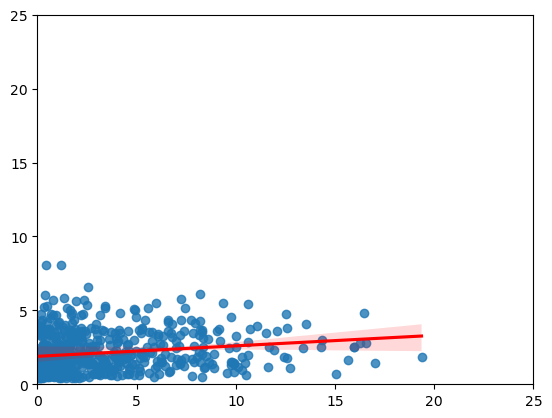

In [27]:


sns.regplot(result_df, x=y_true, y=y_pred, line_kws=dict(color="r"))
n_outlier = int((y_pred > 20).sum())
if n_outlier > 0:
    print(f'{n_outlier=}')
plt.xlim(0, 25)
plt.ylim(0, 25)

In [16]:
(y_pred > 100).sum()

np.int64(1)

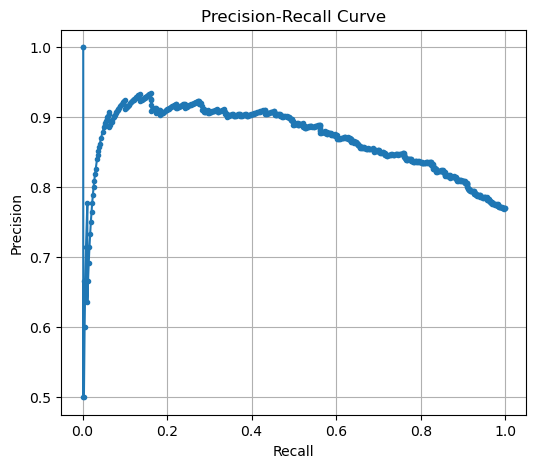

In [13]:
train_utils.plot_precision_recall(y_true, y_prob)

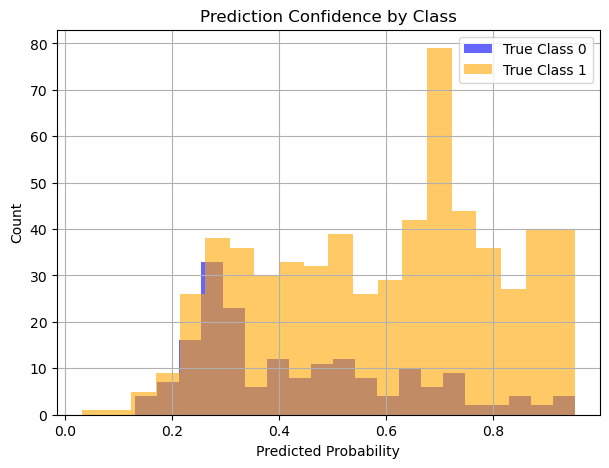

In [14]:
train_utils.plot_prediction_histograms(y_true, y_prob)